In [ ]:
import numpy as np
import pandas as pd
import re
import time
from datasketch import MinHash, MinHashLSHForest
import pickle
import pymongo

Δεδομένων όλων των ομιλιών, πρέπει να ανιχνεύσουμε ομοιότητες ανά ζεύγη μεταξύ των μελών του κοινοβουλίου. Συγκεκριμένα, πρέπει να βρούμε έναν τρόπο να εξαγάγουμε ένα διάνυσμα χαρακτηριστικών για κάθε μέλος και στη συνέχεια να εκτελέσουμε ομοιότητες ανά ζεύγη για να μπορέσουμε να ανιχνεύσουμε τα top-k ζεύγη με τον υψηλότερο βαθμό ομοιότητας (όπου k είναι μια παράμετρος).

In [ ]:
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
#mongo_client.drop_database("GreekParliamentProceedings")
client = mongo_client["GreekParliamentProceedings"]
index = client["InvertedIndex"]
database = client["Database"]
print(type(database))

In [211]:
with open('results/member_keywords.pickle', 'rb') as handle:
    keywords_by_member = pickle.load(handle)
#print(list(keywords_by_member['τσιπρας παυλου αλεξιος'].keys()))
member_names = keywords_by_member.keys()
keywords = [list(keywords_by_member[member].keys()) for member in member_names]

### Διάνυσμα χαρακτηριστικών για κάθε μέλος

In [ ]:
#CREATE A VECTOR FOR EACH MEMBER IN A PANDAS DATAFRAME
member_names = keywords_by_member.keys()
keywords = [list(keywords_by_member[member].keys()) for member in member_names]
genders = []
political_parties = []
member_roles = []
regions = []
governments = []
def get_attributes_by_member(members, collection):
        for member in members:
                print(member)
                pipeline = [{'$match' : {'member_name':member}},
                            {'$facet': {
                                'groupByRoles':[{'$group':{'_id':'$roles'}}],
                                'groupByGender':[{'$group':{'_id':'$member_gender'}}],
                                'groupByGovernment':[{'$group':{'_id':'$government'}}],
                                'groupByParty':[{'$group':{'_id':'$political_party'}}],
                                'groupByRegion':[{'$group':{'_id':'$member_region'}}]
                            }
                                        }
                        ]
                r = list(collection.aggregate(pipeline))
                genders.append(r[0]['groupByGender'][0]['_id'])
                regions.append([r[0]['groupByRegion'][i]['_id'] for i in range(len(r[0]['groupByRegion']))])
                member_roles.append([r[0]['groupByRoles'][i]['_id'] for i in range(len(r[0]['groupByRoles']))])
                governments.append([r[0]['groupByGovernment'][i]['_id'] for i in range(len(r[0]['groupByGovernment']))])
                political_parties.append([r[0]['groupByParty'][i]['_id'] for i in range(len(r[0]['groupByParty']))])
                
        return genders, regions, political_parties, member_roles, governments

In [ ]:
genders, regions, political_parties, member_roles, governments = get_attributes_by_member(member_names, database)

In [ ]:
print(len(member_names))
print(len(keywords))
print(len(genders))
print(len(regions))
print(len(member_roles))
print(len(governments))
print(len(political_parties))

In [ ]:
#CREATE PANDAS DATAFRAME
data = {'Name': member_names,
        'Gender': genders,
        'Region(s)':regions,
        'Role(s)':member_roles,
        'Government(s)':governments,
        'Political party':political_parties,
        'Keywords':keywords}
df = pd.DataFrame(data)
df.head(4)

### Ομοιότητες ανά ζεύγη: MinHash + LSH

In [162]:
# FOLLOWED THE TUTORIAL FROM: https://www.pinecone.io/learn/locality-sensitive-hashing/
# STEP 1. CREATE K SHINGLES FOR EACH VECTOR
def get_k_shingles(vector: list, k: int)->set:
    shingles = []
    if(k>0):
        word = ' '.join(vector)
        for i in range(len(word) - k+1):
            shingles.append(word[i:i+k])
    else:
        for word in vector:
            shingles.append(word)
    return set(shingles)

#all_shingles is a list of sets
def get_vocabulary(all_shingles:list)->set:
    vocab = set()
    for i in range(len(all_shingles)):
        vocab.update(all_shingles[i])
        
    return vocab

In [176]:
all_shingles = []
for list_ in keywords:
    all_shingles.append(get_k_shingles(list_,0))
vocab = get_vocabulary(all_shingles)
#print((vocab))

In [177]:
hash_ = [i for i in range(0, len(vocab))]
print(len(hash_))
from random import shuffle
hashes = []
for i in range(256):
    shuffle(hash_)
    hashes.append(list(hash_))
#shuffle(hash_)
#print(hash_)
#shuffle(hash_)
print(len(hash_))

706
706


In [178]:
print(hashes[4].index(0))
print(hashes[41].index(0))
print(hashes[12].index(0))
print(hashes[123].index(0))

575
572
218
58


In [ ]:
def get_sparse_matrix(num_sets:int, vocab:set, all_shingles:set):
    #CREATE SPARSE MATRIX MxN, WHERE M = LEN(keywords) and N = LEN(vocab)
    matrix = []
    for k in range(num_sets):
        matrix.append([0 for i in range(len(vocab))])
    #print(len(matrix))
    #print(list(vocab).index('συριζ'))
    for i, shingle in enumerate(all_shingles):
        #print(shingle)
        for s in shingle:
            position = list(vocab).index(s)
            matrix[i][position] = 1    
    return matrix

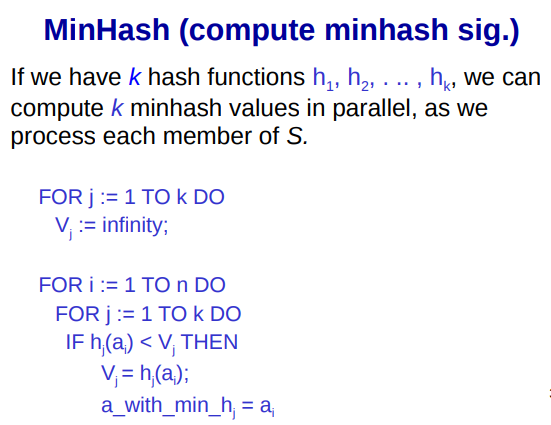

In [182]:
#INITIALISE SIGNATURE MATRIX
signature_matrix = []
for i in range(len(keywords)):
    signature_matrix.append([len(hashes)+10 for i in range(len(hashes))])
print(f'Signature matrix has {len(signature_matrix)} rows and {len(signature_matrix[1])} columns',)
print(f'Sparse matrix has {len(matrix)} rows and {len(matrix[0])} columns',)
print(f'There are {len(hashes)} hashes with {len(hashes[1])} values each',)


Signature matrix has 1523 rows and 256 columns
Sparse matrix has 1523 rows and 706 columns
There are 256 hashes with 706 values each


In [183]:
for i in range(len(matrix[0])):
    #print(f'Checking column {i+1}/{len(matrix[0])}')
    for j in range(len(matrix)):
        if(matrix[j][i]==1):
            # there are k=128 hashes, each hash has i=408 items
            # CRITICAL
            for k, hash_ in enumerate(hashes):
                if(hash_[i]<signature_matrix[j][k]):
                    signature_matrix[j][k] = hash_[i]

In [186]:
print(len(signature_matrix[1]))
print((signature_matrix[0]))
print((signature_matrix[1]))

256
[0, 8, 23, 50, 139, 16, 26, 40, 21, 97, 55, 86, 127, 122, 18, 20, 32, 29, 7, 45, 27, 65, 49, 0, 12, 19, 185, 20, 38, 61, 104, 112, 15, 2, 117, 117, 50, 0, 73, 32, 0, 0, 44, 20, 75, 7, 73, 16, 28, 11, 66, 9, 17, 10, 72, 26, 59, 117, 2, 32, 72, 18, 85, 140, 109, 0, 36, 68, 4, 7, 4, 68, 33, 0, 58, 21, 34, 6, 72, 4, 24, 88, 8, 42, 9, 2, 18, 16, 28, 8, 48, 19, 67, 5, 133, 55, 39, 148, 101, 68, 2, 65, 52, 62, 51, 119, 2, 126, 184, 4, 46, 86, 74, 52, 61, 91, 106, 22, 51, 52, 1, 200, 6, 0, 19, 14, 194, 69, 4, 27, 91, 159, 4, 1, 9, 52, 78, 37, 0, 22, 90, 52, 155, 60, 31, 36, 29, 20, 47, 1, 69, 75, 7, 19, 5, 27, 110, 169, 96, 87, 20, 36, 6, 123, 44, 76, 9, 55, 40, 210, 35, 41, 94, 0, 132, 192, 15, 29, 116, 38, 28, 47, 42, 84, 32, 81, 1, 44, 68, 108, 150, 10, 27, 8, 3, 25, 53, 68, 23, 23, 58, 190, 7, 196, 224, 12, 126, 18, 13, 76, 209, 1, 69, 57, 27, 94, 153, 3, 145, 15, 48, 73, 13, 7, 41, 33, 122, 115, 41, 141, 113, 1, 2, 18, 234, 62, 64, 85, 124, 21, 54, 37, 30, 38, 33, 24, 15, 12, 55, 46, 

### LSH

In [244]:
def jaccard_similarity(signature1: list, signature2: list):
    sim = 0
    sig1 = set(signature1)
    sig2 = set(signature2)
    if(len(sig1.union(sig2))!=0):
        sim = len(sig1.intersection(sig2)) / len(sig1.union(sig2))

    return sim

In [ ]:
test = [[1,2,3,4],[5,6,7,8]]
slice = test[:1]
print([inner[:2] for inner in test[:]])

In [189]:
#SPLIT SIGNATURE MATRIX TO B SUBVECTORS WITH C COLUMNS EACH (MATRIX IS TRANSPOSED)
def split(signature_matrix:list, b:int, columns:int):
    steps = [i for i in range(0,len(signature_matrix[1]), columns)]
    #print(steps)
    steps.append(len(signature_matrix[0]))
    #splits = [signature_matrix[steps[i]:steps[i+1]] for i in range(len(steps)-1)]
    splits = [[signature[steps[i]:steps[i+1]] for signature in signature_matrix[:]] for i in range(len(steps)-1)]
    #for i in range(len(steps)-1):
        #print(steps[i], steps[i+1])
    return splits
bands = 32
rows = 4
bands = split(signature_matrix, 32, 4)
#print(signature_matrix[0])
for i in range(len(vocab)):
    print(bands[0][i])


[0, 8, 23, 50]
[61, 122, 20, 31]
[85, 89, 26, 29]
[19, 106, 40, 45]
[266, 89, 116, 0]
[266, 66, 11, 247]
[236, 13, 26, 29]
[62, 89, 104, 29]
[224, 266, 266, 67]
[20, 13, 4, 9]
[120, 89, 33, 29]
[242, 2, 26, 25]
[62, 122, 26, 51]
[266, 266, 266, 266]
[257, 54, 40, 45]
[32, 13, 64, 29]
[168, 63, 11, 232]
[242, 266, 122, 266]
[187, 266, 6, 266]
[65, 78, 11, 0]
[6, 89, 20, 29]
[43, 266, 26, 266]
[0, 122, 59, 62]
[41, 8, 23, 50]
[60, 266, 26, 51]
[29, 89, 59, 29]
[41, 218, 26, 172]
[242, 266, 266, 266]
[122, 5, 123, 49]
[0, 54, 26, 62]
[120, 128, 160, 83]
[57, 54, 77, 0]
[85, 5, 123, 62]
[216, 122, 207, 182]
[63, 13, 26, 29]
[80, 18, 26, 62]
[89, 180, 266, 156]
[266, 63, 258, 232]
[169, 13, 64, 4]
[85, 106, 26, 62]
[242, 35, 187, 29]
[223, 21, 27, 9]
[62, 189, 26, 51]
[266, 122, 11, 266]
[62, 122, 266, 51]
[195, 13, 64, 62]
[91, 24, 58, 34]
[266, 122, 11, 266]
[152, 76, 217, 147]
[84, 89, 11, 29]
[93, 13, 26, 158]
[78, 13, 26, 218]
[41, 5, 64, 26]
[43, 169, 11, 266]
[43, 89, 20, 29]
[48, 50

In [ ]:
for band in bands:
    for signature_part in band:
        #ToDo: hash signature to bucket
        #http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf

In [187]:
#COMPARE WITH LIBRARY
from datasketch import MinHash, MinHashLSH

set1 = set(keywords[0])
set2 = set(keywords[1])
print(set1)
print(set2)


m1 = MinHash(num_perm=128)
m2 = MinHash(num_perm=128)
for d in set1:
    m1.update(d.encode('utf8'))
for d in set2:
    m2.update(d.encode('utf8'))

print("Estimated Jaccard for data1 and data2 is", m1.jaccard(m2))
print(jaccard_similarity(signature1=signature_matrix[0], signature2=signature_matrix[1]))
print(keywords[0])
print(keywords[1])
# Create LSH index
lsh = MinHashLSH(threshold=0.5, num_perm=128)
lsh.insert("m2", m2)
result = lsh.query(m1)
print("Approximate neighbours with Jaccard similarity > 0.5", result)
print(signature_matrix[1])
print(signature_matrix[0])

{'διαθες', 'δεκτ', 'δημοκρατ', 'επικαιρ ερωτης ', 'συριζ', 'λεπτ', 'δευτερολογ', 'νε', 'αρθρ', 'παρακαλ', 'πλειοψηφ'}
{'αγροτ', 'διαταξ', 'συριζ', 'νομοσχεδ', 'αυξης', 'δικαιωμ'}
Estimated Jaccard for data1 and data2 is 0.0546875
0.4945652173913043
['λεπτ', 'διαθες', 'παρακαλ', 'δημοκρατ', 'νε', 'δευτερολογ', 'συριζ', 'αρθρ', 'δεκτ', 'πλειοψηφ', 'επικαιρ ερωτης ']
['συριζ', 'νομοσχεδ', 'αγροτ', 'διαταξ', 'αυξης', 'δικαιωμ']
Approximate neighbours with Jaccard similarity > 0.5 []
[61, 122, 20, 31, 23, 194, 184, 7, 44, 39, 1, 2, 92, 13, 139, 41, 22, 266, 15, 134, 13, 241, 110, 6, 13, 96, 107, 157, 266, 38, 28, 60, 95, 89, 22, 63, 136, 12, 6, 137, 1, 25, 223, 266, 4, 253, 99, 96, 60, 89, 208, 204, 266, 195, 139, 13, 199, 258, 72, 99, 15, 18, 9, 20, 31, 91, 9, 111, 22, 2, 110, 266, 36, 15, 159, 157, 3, 46, 148, 23, 127, 145, 8, 42, 139, 85, 168, 4, 78, 266, 90, 203, 266, 50, 21, 57, 171, 266, 55, 67, 125, 191, 25, 266, 151, 87, 160, 15, 158, 66, 266, 178, 74, 152, 266, 228, 89, 222, 94, 52

In [192]:
def get_band_buckets(band, hash_funct):
    buckets = {}
    for doc_id in range(0,len(band)):
        value = hash_funct.get_hash_value( band[doc_id] )
        if value not in buckets:
            buckets[value] = [doc_id]
        else:
            buckets[value].append(doc_id)
    return buckets

In [193]:
#SOURCE: https://www.codemotion.com/magazine/backend/fast-document-similarity-in-python-minhashlsh/
import hashlib
# the family of hash functions, in this case, is the same function (sha1) applied with a different salt.
class hashFamily:
    def __init__(self, i):
        self.resultSize = 8 # how many bytes we want back
        self.maxLen = 20 # how long can our salt be (in decimal)
        self.salt = str(i).zfill(self.maxLen)[-self.maxLen:]

    def get_hash_value(self, el_to_hash):
        return int(hashlib.sha1(str(el_to_hash).encode('utf-8') + self.salt.encode('utf-8')).hexdigest()[-self.resultSize:], 16)

# NOTE: we use sha1 to avoid installing and importing an external library, sacrificing performances. No crypto-hash is required for this use case.

In [198]:
from random import randint
f  = hashFamily(randint(0,10000000000))
buckets = []
for band in bands:
    buckets.append(get_band_buckets(bands[0], f))

In [235]:
candidates_pairs = []
import itertools
for bucket in buckets:
    for key in bucket.keys():
        if(len(bucket[key])>1):
            candidates_pairs.extend(list((itertools.combinations(bucket[key], 2))))


In [239]:
print(len(candidates_pairs))

47616


In [254]:
accepted = {}
for pair in candidates_pairs:
    sim = jaccard_similarity(keywords[pair[0]], keywords[pair[1]])
    if(sim>0.7):
        if(sim not in accepted.keys()):
            accepted[sim] = [pair]
        else:
            accepted[sim].append(pair)

[(437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817), (437, 817)]


In [259]:
print(keywords[161])
print(keywords[1325])

['νομοσχεδ']
['νομοσχεδ']


In [249]:
print(accepted)

[(108, 406), (108, 985), (406, 985), (703, 1061), (703, 1399), (703, 1509), (1061, 1509), (1399, 1509), (95, 1216), (161, 1325), (207, 1294), (1259, 1480), (276, 656), (304, 488), (305, 1339), (437, 817), (471, 1386), (481, 1504), (626, 796), (108, 406), (108, 985), (406, 985), (703, 1061), (703, 1399), (703, 1509), (1061, 1509), (1399, 1509), (95, 1216), (161, 1325), (207, 1294), (1259, 1480), (276, 656), (304, 488), (305, 1339), (437, 817), (471, 1386), (481, 1504), (626, 796), (108, 406), (108, 985), (406, 985), (703, 1061), (703, 1399), (703, 1509), (1061, 1509), (1399, 1509), (95, 1216), (161, 1325), (207, 1294), (1259, 1480), (276, 656), (304, 488), (305, 1339), (437, 817), (471, 1386), (481, 1504), (626, 796), (108, 406), (108, 985), (406, 985), (703, 1061), (703, 1399), (703, 1509), (1061, 1509), (1399, 1509), (95, 1216), (161, 1325), (207, 1294), (1259, 1480), (276, 656), (304, 488), (305, 1339), (437, 817), (471, 1386), (481, 1504), (626, 796), (108, 406), (108, 985), (406, 9